This is a python translation of a MATLAB script Rowena sent to me in January, 2023. This notebook creates synthetic displacement time series (same rate, random noise added for nn iterations) and does an inversion with made-up coherence values. 

This notebook: <br>
1. creates displacement data by adding noise to a constant velocity time series (line). This has irregularly-sampled time intervals to show that it works without constant dt.
2. makes coherence values to accompany the data, one value has higher error/standard deviation 
3. creates covariance matrix using noise levels defined above.
4. Inverts a few different ways: using displacements, disp rates, unweighted and weighted.
5. Plots everything.

This notebook was written on 12-19-22. Most recently edited 1-26-23.

***

In [16]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
%matplotlib  widget

Create synthetic data.

In [17]:
nd = 10                     # number of dates
nn = 100000                 # number of noise iterations to calc statistics
V = 4                       # velocity 
Sig = 1.0*np.ones((nd,))    # noise (std. dev.s) vector 
print(np.shape(Sig))
#Sig[7] = 1                  # bigger noise on the 8th date
print('Sig: '+str(Sig))
Sigm = np.diag(Sig,0)       # same as Cd?
print('Sigm: \n'+str(Sigm))

# Make an array of dates, with first time interval twice as long as the others.
# this shows that the approach doesn't require constant time intervals.
t = np.linspace(0,1,nd+1)
t = np.hstack((t[0],t[2::])); t=t.T
print('t: '+str(t))

# vector of displacement (D) and noise (N) and noisy disp (DN)
D = V*t                                 # true displacements
D2 = np.array([D]*nn).T                 # repeat D for all the columns (nn columns) of a bigger array D2 
N = Sigm.dot(np.random.randn(nd,nn))    # noise for every igram for every iteration 
N2 = np.zeros((nd-1,nn));               # set up second noise array to add extra noise to one igram 
N2[2,:] = 0.8*np.random.randn(nn)       # adds more noise to a single igram. 
#N3 = np.zeros(nd-1); N3[2]=0.8          # to add back in the igram-related noise we get from data 
DN = N+D2                               # adding in second layer of noise (igram-related on 3rd igram)

# coherence
coh = np.exp(-(Sig**2)/2) 
print('coh: '+str(coh)) 

(10,)
Sig: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Sigm: 
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
t: [0.  0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
coh: [0.60653066 0.60653066 0.60653066 0.60653066 0.60653066 0.60653066
 0.60653066 0.60653066 0.60653066 0.60653066]


In [18]:
# Make design matrix of interferograms 
diags = np.ones((nd-1))
Gint = np.diag(diags,1)-1*np.eye(nd)
Gint = Gint[0:-1,:]
print(Gint)

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


In [19]:
# values to loop over for multiplying the Sigmas to get a big range of Sigm values (date-related noise)
multiples = np.arange(-100.0,101.0,1.0)
for i in range(len(multiples)):
    multiples[i] = 10**multiples[i]
vels = np.zeros(len(multiples),)
errors = np.zeros(len(multiples),)

In [20]:
for i in range(len(multiples)):
    Sigm2 = Sigm*multiples[i]
    # now diagonals of created covariance matrix are 1's instead of the true value 0.5
    # How does this affect the result? 
    covi = (Gint.dot(Sigm2**2)).dot(Gint.T)     # interferogram covariance matrix
    #covi = covi + np.diag(N3,0)                                 
    icov = np.linalg.inv(covi)                  # inverse of covariance matrix
    # interferograms 
    ints = Gint.dot(DN) 
    ints = ints+N2                              # noisy interferograms
    dt = Gint.dot(t)                            # time intervals 
    covin = np.cov(ints)  
    # inversion using just dt from ints
    Gt = dt; Gt = Gt.reshape((nd-1,1))
    Ggtb = np.linalg.inv(Gt.T.dot(icov).dot(Gt)).dot(Gt.T).dot(icov)        # weights 
    # now do the inversion for displacement, followed by inversion for V           
    Vtb = Ggtb.dot(ints)                # weighted inversion directly from ints (weighted mean of velocities)
    vels[i] = np.mean(Vtb)
    errors[i] = st.stdev(Vtb[0,:])

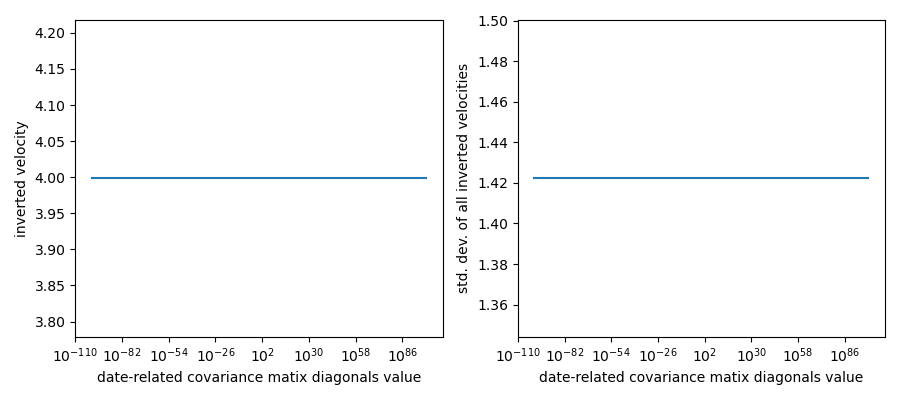

In [21]:
plt.figure(figsize=(9,4),tight_layout=True)
plt.subplot(1,2,1)
plt.semilogx(multiples,vels)
plt.xlabel('date-related covariance matix diagonals value')
plt.ylabel('inverted velocity')
plt.subplot(1,2,2)
plt.semilogx(multiples,errors)
plt.xlabel('date-related covariance matix diagonals value')
plt.ylabel('std. dev. of all inverted velocities')
plt.show()